In [12]:
# Basic tools :
import numpy as np                      
import pandas as pd  

# Plot
import matplotlib.pyplot as plt         
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler,LabelBinarizer 
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# Predictors :
from sklearn.linear_model import LinearRegression,LogisticRegression, LogisticRegressionCV, RidgeCV, LassoCV, ElasticNet
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
# from sklearn import neighbors 
# from sklearn.naive_bayes import GaussianNB , ComplementNB,CategoricalNB              

# Metrics : 
from sklearn.metrics import mean_squared_error, r2_score,roc_curve, roc_auc_score, auc 
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score, accuracy_score

# Optimization / Validation :
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score

from sklearn import svm, datasets,preprocessing

# cell multiple outputs
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Others :
from itertools import cycle
from scipy import interp
from sklearn.pipeline import Pipeline
import time

from sklearn.decomposition import PCA

In [13]:
# training set
lacentrale = pd.read_csv('lacentrale_clean_finale.csv')
# test set
beke = pd.read_csv('beke_processed.csv')

# Preprocessing

Objectif : établir des pipelines pour implémentations dans Flask

### Pipelines

In [14]:
def preprocessing():

    # on définit les colonnes et les transformations pour 
    # les colonnes quantitatives
    col_quanti=['nb_km','nb_portes','nb_places','conso_mixte','p_fiscale','p_din']
    
    transfo_quanti = Pipeline(steps=[
        ('imputation', SimpleImputer(strategy='median')),
        ('standard', StandardScaler())])

    # on définit les colonnes et les transformations pour
    # les variables qualitatives

    #variables ordinales
    #le mapping = ordinal_cols_mapping
    ordinal_cols_mapping = [
        {
        "col":'co2',    
        "mapping": {
            'A':4, 
            'B':3, 
            'C':2, 
            'D':1,       
        }},

        {
        "col":'critair',    
        "mapping": {
            1:3, 
            2:2, 
            3:1,       
        }} 
    ]

    # qualitatives ordinales
    col_quali_ord = ['co2','critair',]
    transfo_quali_ord = Pipeline(steps=[
        ('ordinalEncoder', OrdinalEncoder(mapping=ordinal_cols_mapping, return_df = True))
    ])

    # qualitatives nominales
    col_quali_nom= ['marque','modele','categorie','carburant','boite_vitesse','couleur','mise_circulation' ]
    transfo_quali_nom = Pipeline(steps=[
        ('imputation', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # on définit l'objet de la classe ColumnTransformer
    # qui va permettre d'appliquer toutes les étapes
    preparation = ColumnTransformer(
        transformers=[
            ('quanti', transfo_quanti , col_quanti),
            ('quali_ord', transfo_quali_ord , col_quali_ord),
            ('quali_nom', transfo_quali_nom , col_quali_nom)
        ], remainder='drop')
    
    return preparation 

# on stocke la préparation
preparation = preprocessing()

### Paramètres pour GridsearchCV

In [31]:
# Paramètres pour la gridsearch
regression = {
        
       'RF': { 'model':RandomForestRegressor(),
              'param':{
                  'clf__n_estimators': [100,200,300],
                'clf__max_depth': [1,5,10],
#                   'clf__min_samples_split': [1,5,10,15]
#                   'cl_max_leaf_nodes': [ 100, 200, 300, 400, 500, 600, 650, 700, 800]
                  },
             },
        

        'Lasso': { 'model': LassoCV(),
                'param': {'clf__alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
             },
    
        'Ridge': { 'model': RidgeCV(),
                'param': {'clf__alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
             },
    
        'Elastic': { 'model': ElasticNet(),
                'param': {'clf__alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'clf__l1_ratio' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
                         }
             },
    
        'LR': { 'model': LogisticRegression(),
                'param': {'clf__penalty' : ['l1', 'l2'], 'clf__C' : np.logspace(-4, 4, 20), 'clf__solver' : ['liblinear']},
             },
       
        'SVR':{ 'model': SVR(),
                'param': {'clf__C': [0.1,1, 10, 100], 'clf__gamma': [1,0.1,0.01,0.001],'clf__kernel': ['rbf', 'poly', 'sigmoid'],
                         },
             },
      
        'XGB':{ "model":XGBRegressor(),
              "param":{"clf__learning_rate": [0.05,1,5],
                       'clf__n_estimators': [100,50],
#                        "clf__max_depth": [5,10,15]
                  },
            },
    
        'GradientBoost':{ "model":GradientBoostingRegressor(),
              "param":{"clf__model__alpha": [0.0, 0.5, 1.0],
                        "clf__ccp_alpha": [0.0, 0.5]
                  },
            },
    
        'decisionTree':{ "model":GradientBoostingRegressor(),
              "param":{"clf__criterion": ['mse', 'mae'],
                'clf__min_samples_leaf': [5, 10, 15, 20, 25],
                'clf__max_depth': [6, 9, 12, 15, 20],
                  },
            },
         
        
}

In [16]:
# A simple transformer that converts a sparse into a dense numpy array, e.g., 
# required for scikit-learn's Pipeline when, for example, 
# CountVectorizers are used in combination with estimators 
# that are not compatible with sparse matrices.

from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

### Implémentation

In [28]:
# Cette fonction prend en entrée le nom du regresseur utilisé et les deux datasets (train=lacentrale, test=beke) :
#     1. Définition de la pipeline de préparation à passer au modèle : 'model', à partir des pipelines précédentes.
#     2. Split du dataset train avec sélection des colonnes à garder.
#     3. Training du modèle avec GridsearchCV inclue.
#     4. Préparation du dataset test.
#     5. Prédiction
#     6. Return prédictions ou comparaison des deux prix prédits


def modele_entier(cl, df_train, df_test):
    model = Pipeline(steps=[('preparation', preparation),
                            ('to_dense', DenseTransformer()),
                         ('clf', cl['model'] )
                    ])
    
    # ---------- PROCESSING & ENTRAINEMENT ----------

    param_grid = cl['param']

#     on sépare la cible du reste des données (dataset d'entraînement) 
    X = df_train.drop(['prix','nom','ref'], axis=1) # ON GARDE TOUTES LES COLONNES
#     X = df_train.drop(['nom', 'ref', 'co2', 'carburant', 'couleur', 'nb_portes', 'nb_places',
       'conso_mixte', 'p_din', 'critair', 'prix'], axis=1) # ON GARDE LES COLONNES CORRELEES FORTEMENT


    y = df_train['prix']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
    
    # Debut du decompte du temps
    start_time = time.time()

    # Model training avec Gridsearch
    grid = GridSearchCV(estimator=model, 
                        param_grid=param_grid, 
                        n_jobs=-1, cv=10, verbose=False, 
                        scoring='neg_root_mean_squared_error'
)
    grid.fit(X_train,y_train)
    
    print(grid.best_estimator_)
    
    # Score de l'entraînement
    rmse = grid.score(X_test, y_test)
    print(("RMSE  : %.5f" % rmse))
    
    # Temps d'entraînement
    times = (time.time() - start_time)
    print("Temps d'entraînement' : %s secondes ---" % times)    

    
    # --------------- PREDICTIONS ---------------
    
#     on sépare la cible du reste des données (dataset de test) 
    X_reel = df_test.drop(['prix','nom','ref'], axis=1) # ON GARDE TOUTES LES COLONNES
#     X_reel = df_test.drop(['prix','nom','ref'], axis=1) # ON GARDE LES COLONNES CORRELEES FORTEMENT

    y_reel = df_test['prix']  
    
    y_pred = grid.predict(X_reel)   
    
    dic = {
    "prix_prediction": y_pred,
    "prix_beke":beke['prix'].values,
    "p_beke-p_pred":beke['prix'].values - y_pred,
    }

    comparaison = pd.DataFrame(data=dic)
                                    
    return comparaison

svr_comp = modele_entier(regression['SVR'], lacentrale, beke)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('quanti',
                                                  Pipeline(memory=None,
                                                           steps=[('imputation',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [47]:
svr_comp.describe()

,prix_prediction,prix_beke,p_beke-p_pred
count,359.000000,359.000000,359.000000
mean,17353.581103,16600.086351,-753.494752
std,6631.898764,5373.845744,2574.048851
min,8663.146143,9126.000000,-18569.115008
25%,12418.208897,13104.000000,-2220.932596
50%,15389.371517,14226.000000,-809.747934
75%,20473.044608,19326.000000,571.933972
max,46797.115008,34728.000000,13141.511664


In [29]:
elastic_result = modele_entier(regression['Elastic'], lacentrale, beke)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('quanti',
                                                  Pipeline(memory=None,
                                                           steps=[('imputation',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [48]:
elastic_result.describe()

,prix_prediction,prix_beke,p_beke-p_pred
count,359.000000,359.000000,359.000000
mean,18470.340996,16600.086351,-1870.254645
std,6979.437698,5373.845744,2823.236198
min,5687.387719,9126.000000,-10665.946767
25%,13228.005468,13104.000000,-3335.035966
50%,18018.574777,14226.000000,-1431.632201
75%,22061.391788,19326.000000,330.612740
max,43334.493132,34728.000000,4001.347811


In [32]:
rfr_result = modele_entier(regression['RF'], lacentrale, beke)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('quanti',
                                                  Pipeline(memory=None,
                                                           steps=[('imputation',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [50]:
rfr_result.describe()

,prix_prediction,prix_beke,p_beke-p_pred
count,359.000000,359.000000,359.000000
mean,18038.427019,16600.086351,-1438.340668
std,5808.604917,5373.845744,1429.835367
min,10366.914920,9126.000000,-6289.279631
25%,13922.422097,13104.000000,-2201.742870
50%,15908.302495,14226.000000,-1423.559056
75%,21699.770194,19326.000000,-699.616014
max,35504.310881,34728.000000,4430.284669


# Conclusion :

* Les pipelines intègrent preprocessing, training, gridsearchCV et prédiction.
    * RMSE scores :
        * SVR: 2483
        * ElasticNet: 2497
        * RandomForestRegressor: 2574
* Les prix de Beke sont plus bas que ceux de La Centrale.
* Il y a beaucoup trop de colonnes pour faire une application Flask intéressante.

# Sélection des colonnes corrélées

(6, 6)


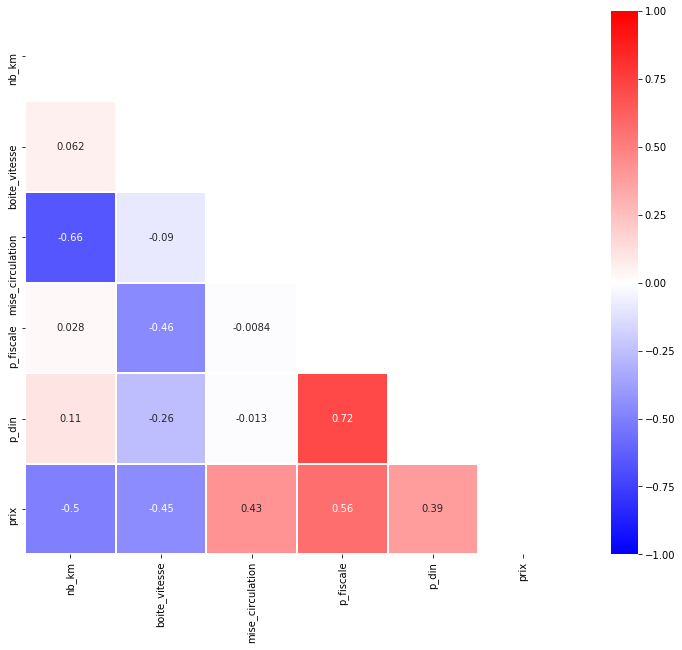

In [54]:
# Corrélation pour lister les colonnes à garder. cf. analyse préliminaire des données.
def manual_prepraration (df):
    
    df = df.drop(['nom','ref'], axis=1)

    col_quanti=['nb_km','nb_portes','nb_places','conso_mixte','p_fiscale','p_din']
    quanti_imputer = SimpleImputer(strategy='median')
    scal = StandardScaler()

    ordinal_cols_mapping = [
            {
            "col":'co2',    
            "mapping": {
                'A':4, 
                'B':3, 
                'C':2, 
                'D':1,       
            }},

            {
            "col":'critair',    
            "mapping": {
                1:3, 
                2:2, 
                3:1,       
            }} 
        ]
    col_quali_ord = ['co2','critair']
    ordenc = OrdinalEncoder(mapping=ordinal_cols_mapping, return_df = True)

    quali_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
    quali_encoder = OneHotEncoder(handle_unknown='ignore')
    
    df[col_quanti] = quanti_imputer.fit_transform(df[col_quanti])
    df[col_quali_ord] = ordenc.fit_transform(df[col_quali_ord])
    
    object_col = []
    le = LabelEncoder()    
    
    for col in df.columns:
        if df[col].dtypes == object:
            object_col.append(col)

            le.fit(df[col])
            df[col] = le.transform(df[col])

    return df


df = manual_prepraration (lacentrale)
plot_matrix(df, 0.35,'prix')

In [40]:
def preprocessing_2():

    # on définit les colonnes et les transformations pour 
    # les colonnes quantitatives
    col_quanti=['nb_km','p_fiscale']
    
    transfo_quanti = Pipeline(steps=[
        ('imputation', SimpleImputer(strategy='median')),
        ('standard', StandardScaler())])

    # on définit les colonnes et les transformations pour
    # les variables qualitatives

    # qualitatives nominales
    col_quali_nom= ['marque','modele','categorie','boite_vitesse', 'mise_circulation' ]
    transfo_quali_nom = Pipeline(steps=[
        ('imputation', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # on définit l'objet de la classe ColumnTransformer
    # qui va permettre d'appliquer toutes les étapes
    preparation = ColumnTransformer(
        transformers=[
            ('quanti', transfo_quanti , col_quanti),
            ('quali_nom', transfo_quali_nom , col_quali_nom)
        ], remainder='drop')
    
    return preparation 

# on stocke la préparation
preparation_2 = preprocessing_2()

In [41]:
# Cette fonction prend en entrée le nom du regresseur utilisé et les deux datasets (train=lacentrale, test=beke) :
#     1. Définition de la pipeline de préparation à passer au modèle : 'model', à partir des pipelines précédentes.
#     2. Split du dataset train avec sélection des colonnes à garder.
#     3. Training du modèle avec GridsearchCV inclue.
#     4. Préparation du dataset test.
#     5. Prédiction
#     6. Return prédictions ou comparaison des deux prix prédits


def modele_entier_2(cl, df_train, df_test):
    model = Pipeline(steps=[('preparation', preparation_2),
                            ('to_dense', DenseTransformer()),
                         ('clf', cl['model'] )
                    ])
    
    # ---------- PROCESSING & ENTRAINEMENT ----------

    param_grid = cl['param']

#     on sépare la cible du reste des données (dataset d'entraînement) 
#     X = df_train.drop(['prix','nom','ref'], axis=1) # ON GARDE TOUTES LES COLONNES
    X = df_train.drop(['nom', 'ref', 'co2', 'carburant', 'couleur', 'nb_portes', 'nb_places',
       'conso_mixte', 'p_din', 'critair', 'prix'], axis=1) # ON GARDE LES COLONNES CORRELEES FORTEMENT


    y = df_train['prix']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
    
    # Debut du decompte du temps
    start_time = time.time()

    # Model training avec Gridsearch
    grid = GridSearchCV(estimator=model, 
                        param_grid=param_grid, 
                        n_jobs=-1, cv=10, verbose=False, 
                        scoring='neg_root_mean_squared_error'
)
    grid.fit(X_train,y_train)
    
    print(grid.best_estimator_)
    
    # Score de l'entraînement
    rmse = grid.score(X_test, y_test)
    print(("RMSE  : %.5f" % rmse))
    
    # Temps d'entraînement
    times = (time.time() - start_time)
    print("Temps d'entraînement' : %s secondes ---" % times)    

    
    # --------------- PREDICTIONS ---------------
    
#     on sépare la cible du reste des données (dataset de test) 
#     X_reel = df_test.drop(['prix','nom','ref'], axis=1) # ON GARDE TOUTES LES COLONNES
    X_reel = df_test.drop(['nom', 'ref', 'co2', 'carburant', 'couleur', 'nb_portes', 'nb_places',
       'conso_mixte', 'p_din', 'critair', 'prix'], axis=1) # ON GARDE LES COLONNES CORRELEES FORTEMENT

    y_reel = df_test['prix']  
    
    y_pred = grid.predict(X_reel)   
    
    dic = {
    "prix_prediction": y_pred,
    "prix_beke":beke['prix'].values,
    "p_beke-p_pred":beke['prix'].values - y_pred,
    }

    comparaison = pd.DataFrame(data=dic)
                                    
    return comparaison

svr_comp_2 = modele_entier_2(regression['SVR'], lacentrale, beke)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('quanti',
                                                  Pipeline(memory=None,
                                                           steps=[('imputation',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [46]:
svr_comp_2.describe()

,prix_prediction,prix_beke,p_beke-p_pred
count,359.000000,359.000000,359.000000
mean,16410.950375,16600.086351,189.135976
std,5753.796942,5373.845744,2023.535456
min,7216.663012,9126.000000,-12285.104944
25%,11550.260732,13104.000000,-1332.680151
50%,16163.036837,14226.000000,457.551205
75%,19671.620990,19326.000000,1587.074235
max,40513.104944,34728.000000,10709.207454


In [42]:
elastic_comp_2 = modele_entier_2(regression['Elastic'], lacentrale, beke)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('quanti',
                                                  Pipeline(memory=None,
                                                           steps=[('imputation',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [51]:
elastic_comp_2.describe()

,prix_prediction,prix_beke,p_beke-p_pred
count,359.000000,359.000000,359.000000
mean,17287.605926,16600.086351,-687.519575
std,6460.722407,5373.845744,2051.259824
min,5500.240614,9126.000000,-5796.979687
25%,11853.343979,13104.000000,-2339.517632
50%,16411.618824,14226.000000,-861.146439
75%,21061.878010,19326.000000,1358.529393
max,36343.808714,34728.000000,3625.759386


In [44]:
rf_comp_2 = modele_entier_2(regression['RF'], lacentrale, beke)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('quanti',
                                                  Pipeline(memory=None,
                                                           steps=[('imputation',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [52]:
rf_comp_2.describe()

,prix_prediction,prix_beke,p_beke-p_pred
count,359.000000,359.000000,359.000000
mean,17316.905474,16600.086351,-716.819123
std,6374.579778,5373.845744,1986.532753
min,10778.046585,9126.000000,-6856.501493
25%,11317.115360,13104.000000,-1789.394411
50%,14691.296986,14226.000000,-671.517819
75%,21227.290899,19326.000000,923.665512
max,35464.973680,34728.000000,2591.171001


# Conclusion

* Après sélection des colonnes, les scores RMSE diminuent sensiblement.

* Beke reste moins cher que La Centrale

* Comparatif des scores :

| regressor | RMSE1 | RMSE2 |
|-|-|-|
|SVR|2483|2946|
|ElasticNet|2497|2685|
|RandomForestRegressor: |2574|2737|


# Points à améliorer 

* Essayer de faire une analyse PCA pour voir si cela améliore les résultats
* Rendre plus flexibles les pipelines vis-à-vis des colonnes à garder/écarter
* Rendre plus robustes les pipelines vis-à-vis des autres algorithmes
